In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


#  寶可夢自動編碼器 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.3.7
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.3.1.


In [3]:
dataset=T.load_examples_data('pokemon')

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
get pokemon images :1444


In [4]:
dataset.image_transform_funcs=[resize((130,130)),
                               random_crop(128,128),
                               normalize(127.5,127.5)]       

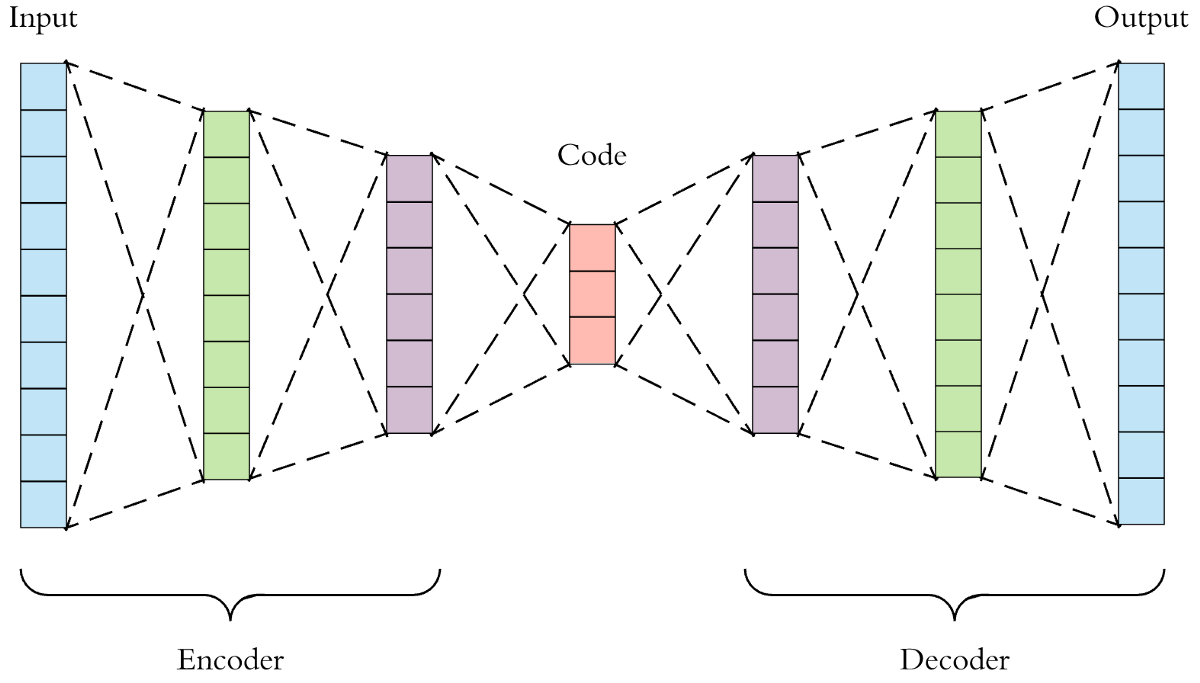

In [5]:
display.Image('../images/autoencoder.png',width=600)

In [6]:

encoder=Sequential(
    Conv2d_Block((5,5),32,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False, add_noise=True,noise_intensity=0.05),#(32,128,128)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    Conv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False,dropout_rate=0.5),#(128,16,16)
    Conv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    Conv2d_Block((3,3),256,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Conv2d_Block((3,3),256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(256,4,4)
    Reshape((-1,1,1)), #(256*4*4)
    Conv2d((1,1),128,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)


decoder=Sequential(
    Conv2d((1,1),128*4*4,strides=1,auto_pad=True,activation='tanh',use_bias=False), #(2048,1,1 )
    Reshape((128,4,4)), #(128,4,4))
    Conv2d_Block((3,3),128,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False) ,#((128,4,4))
    TransConv2d_Block((3,3),128,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(128,8,8)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,16,16)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,32,32)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,64,64)
    TransConv2d_Block((3,3),64,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch',use_bias=False),#(64,128,128)
    Conv2d((1,1),3,strides=1,auto_pad=True,activation='tanh',use_bias=False)
)




In [7]:
autoencoder=Sequential(
    encoder,
    decoder
)

In [8]:
model=Model(input_shape=[3,128,128],output=autoencoder)\
    .with_optimizer(optimizer='Ranger',lr=2e-3,betas=(0.9, 0.999))\
    .with_loss(MSELoss,loss_weight=1,name='l2 loss')\
    .with_loss(EdgeLoss,loss_weight=0.2,name='edge loss')\
    .with_metric(rmse,name='rmse')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/pokemon_ae.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='rmse',mode='min',factor=0.5,patience=3,cooldown=2,threshold=5e-5,warmup=0)\

model.summary()
    



--------------------------------------------------------------------------------------------------------------------------------
                            Layer (type)                   Output Shape                    Weight Shape      Bias Shape          Param #          FLOPS #
                               conv2d_17             [-1, 32, 128, 128]                   [32, 3, 5, 5]                            2,400     78,626,816.0
                            batch_norm_1             [-1, 32, 128, 128]                            [32]            [32]               64      1,556,480.0
                         conv2d__block_1             [-1, 32, 128, 128]                                                                0              0.0
                               conv2d_18               [-1, 64, 64, 64]                  [64, 32, 3, 3]                           18,432    150,990,848.0
                            batch_norm_2               [-1, 64, 64, 64]                            [6

C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [9]:
plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(dataset)\
    .repeat_epochs(250)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(1,unit='epoch')\
    .save_model_scheduling(10,unit='epoch')\
    .display_loss_metric_curve_scheduling(frequency=10,unit='epoch',imshow=True)\
    .display_tile_image_scheduling(5,'epoch','Results/','pokemon_ae_{0}.png',True,True,False,False,True)
#這邊api有調整過，存檔路徑會改成在模型層級設定


model 0          Step: 29s753ms | Loss: 0.060   | Rmse: 21.863%  | learning rate: 6.250e-05  ( 200/250 )
model 0          Step: 27s51ms  | Loss: 0.060   | Rmse: 21.850%  | learning rate: 6.250e-05  ( 201/250 )
learning rate changed! ( form 6.250e-05 to 3.125e-05)

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.125e-05.
model 0          Step: 25s926ms | Loss: 0.060   | Rmse: 21.863%  | learning rate: 3.125e-05  ( 202/250 )
model 0          Step: 25s760ms | Loss: 0.060   | Rmse: 21.862%  | learning rate: 3.125e-05  ( 203/250 )
model 0          Step: 25s523ms | Loss: 0.060   | Rmse: 21.832%  | learning rate: 3.125e-05  ( 204/250 )


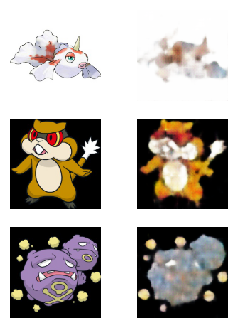

model 0          Step: 26s288ms | Loss: 0.060   | Rmse: 21.858%  | learning rate: 3.125e-05  ( 205/250 )
model 0          Step: 25s881ms | Loss: 0.060   | Rmse: 21.848%  | learning rate: 3.125e-05  ( 206/250 )
model 0          Step: 33s143ms | Loss: 0.060   | Rmse: 21.816%  | learning rate: 3.125e-05  ( 207/250 )
model 0          Step: 27s884ms | Loss: 0.060   | Rmse: 21.817%  | learning rate: 3.125e-05  ( 208/250 )
model 0          Step: 26s219ms | Loss: 0.060   | Rmse: 21.824%  | learning rate: 3.125e-05  ( 209/250 )


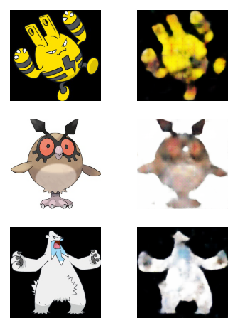

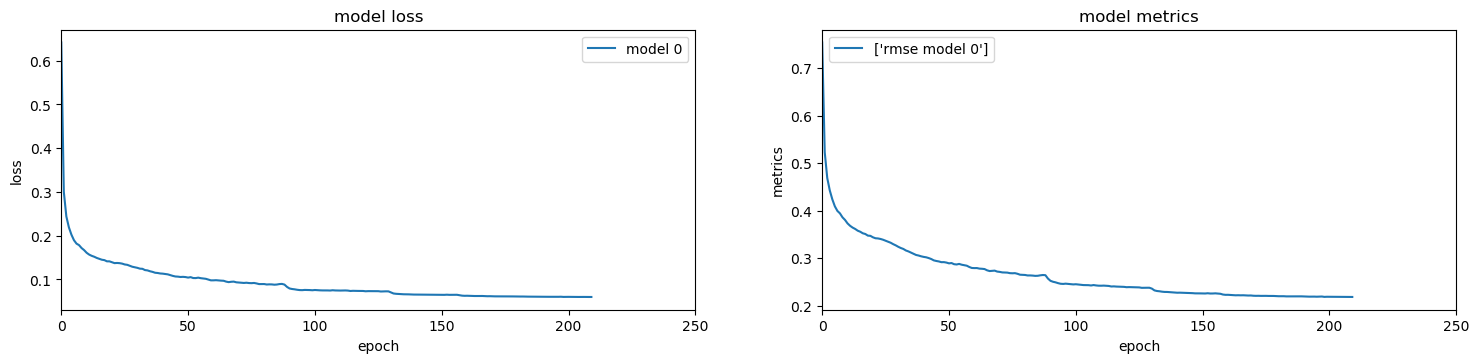

model 0          Step: 30s723ms | Loss: 0.060   | Rmse: 21.816%  | learning rate: 3.125e-05  ( 210/250 )
learning rate changed! ( form 3.125e-05 to 1.563e-05)

Epoch 00211: ReduceLROnPlateau reducing learning rate to 1.5625e-05.
model 0          Step: 27s330ms | Loss: 0.060   | Rmse: 21.847%  | learning rate: 1.563e-05  ( 211/250 )
model 0          Step: 30s185ms | Loss: 0.060   | Rmse: 21.807%  | learning rate: 1.563e-05  ( 212/250 )
model 0          Step: 27s638ms | Loss: 0.060   | Rmse: 21.802%  | learning rate: 1.563e-05  ( 213/250 )
model 0          Step: 28s187ms | Loss: 0.060   | Rmse: 21.833%  | learning rate: 1.563e-05  ( 214/250 )


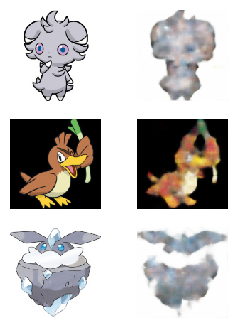

model 0          Step: 27s863ms | Loss: 0.060   | Rmse: 21.803%  | learning rate: 1.563e-05  ( 215/250 )
learning rate changed! ( form 1.563e-05 to 7.813e-06)

Epoch 00216: ReduceLROnPlateau reducing learning rate to 7.8125e-06.
model 0          Step: 29s13ms  | Loss: 0.060   | Rmse: 21.790%  | learning rate: 7.813e-06  ( 216/250 )
model 0          Step: 28s221ms | Loss: 0.060   | Rmse: 21.814%  | learning rate: 7.813e-06  ( 217/250 )
model 0          Step: 27s301ms | Loss: 0.060   | Rmse: 21.798%  | learning rate: 7.813e-06  ( 218/250 )
model 0          Step: 32s150ms | Loss: 0.060   | Rmse: 21.812%  | learning rate: 7.813e-06  ( 219/250 )
learning rate changed! ( form 7.813e-06 to 3.906e-06)

Epoch 00220: ReduceLROnPlateau reducing learning rate to 3.90625e-06.


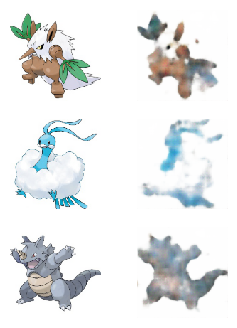

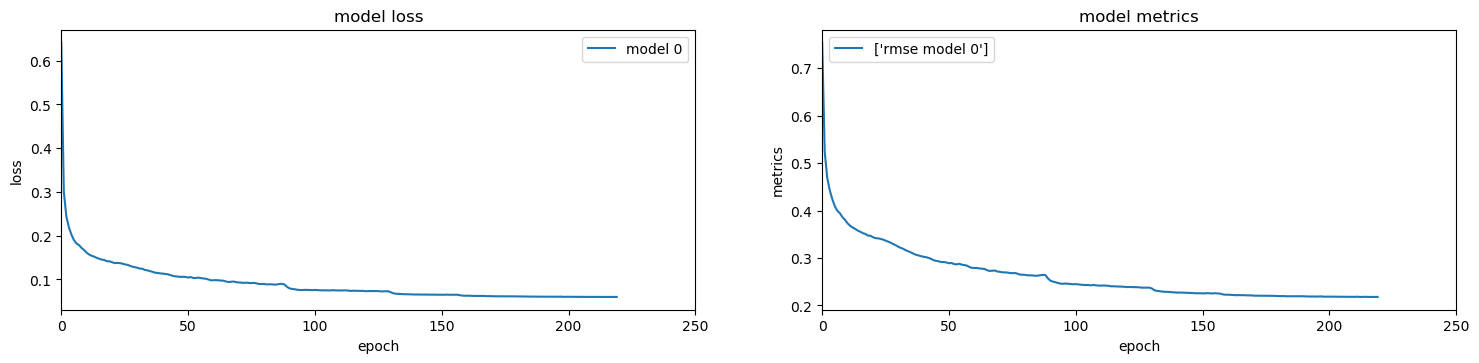

model 0          Step: 30s283ms | Loss: 0.060   | Rmse: 21.822%  | learning rate: 3.906e-06  ( 220/250 )
model 0          Step: 28s696ms | Loss: 0.060   | Rmse: 21.809%  | learning rate: 3.906e-06  ( 221/250 )
model 0          Step: 29s213ms | Loss: 0.060   | Rmse: 21.816%  | learning rate: 3.906e-06  ( 222/250 )
model 0          Step: 30s271ms | Loss: 0.060   | Rmse: 21.816%  | learning rate: 3.906e-06  ( 223/250 )
learning rate changed! ( form 3.906e-06 to 1.953e-06)

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.953125e-06.
model 0          Step: 30s806ms | Loss: 0.060   | Rmse: 21.802%  | learning rate: 1.953e-06  ( 224/250 )


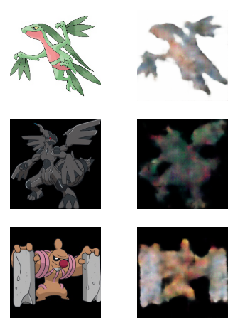

model 0          Step: 32s215ms | Loss: 0.060   | Rmse: 21.784%  | learning rate: 1.953e-06  ( 225/250 )
model 0          Step: 29s304ms | Loss: 0.060   | Rmse: 21.821%  | learning rate: 1.953e-06  ( 226/250 )
model 0          Step: 28s457ms | Loss: 0.060   | Rmse: 21.814%  | learning rate: 1.953e-06  ( 227/250 )
model 0          Step: 27s746ms | Loss: 0.060   | Rmse: 21.774%  | learning rate: 1.953e-06  ( 228/250 )
model 0          Step: 29s79ms  | Loss: 0.060   | Rmse: 21.798%  | learning rate: 1.953e-06  ( 229/250 )


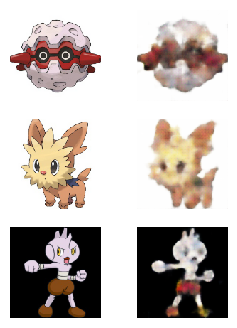

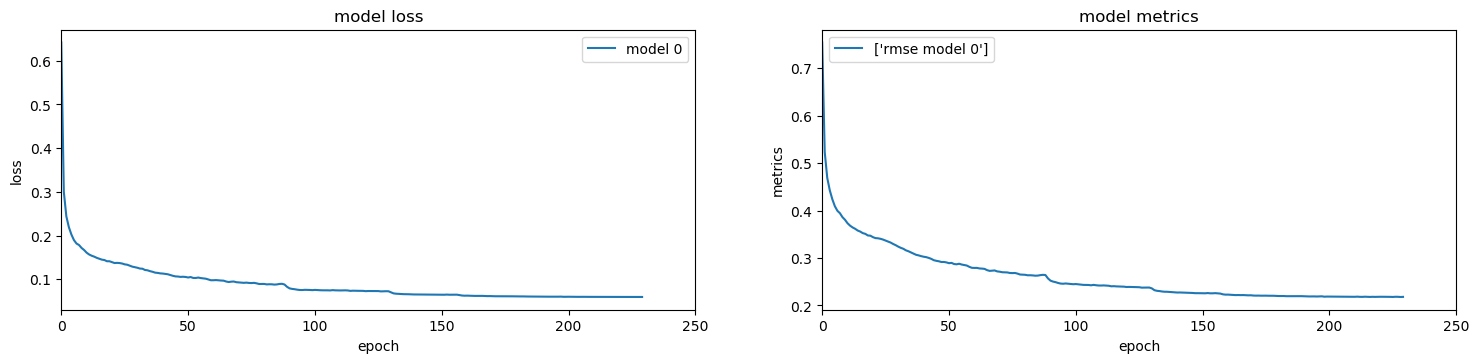

model 0          Step: 33s460ms | Loss: 0.060   | Rmse: 21.777%  | learning rate: 1.953e-06  ( 230/250 )
model 0          Step: 33s733ms | Loss: 0.060   | Rmse: 21.815%  | learning rate: 1.953e-06  ( 231/250 )
learning rate changed! ( form 1.953e-06 to 9.766e-07)

Epoch 00232: ReduceLROnPlateau reducing learning rate to 9.765625e-07.
model 0          Step: 27s408ms | Loss: 0.060   | Rmse: 21.814%  | learning rate: 9.766e-07  ( 232/250 )
model 0          Step: 26s590ms | Loss: 0.060   | Rmse: 21.792%  | learning rate: 9.766e-07  ( 233/250 )
model 0          Step: 28s      | Loss: 0.060   | Rmse: 21.801%  | learning rate: 9.766e-07  ( 234/250 )


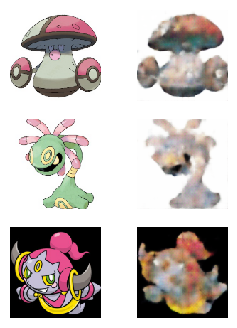

model 0          Step: 38s427ms | Loss: 0.060   | Rmse: 21.798%  | learning rate: 9.766e-07  ( 235/250 )
learning rate changed! ( form 9.766e-07 to 4.883e-07)

Epoch 00236: ReduceLROnPlateau reducing learning rate to 4.8828125e-07.
model 0          Step: 33s249ms | Loss: 0.060   | Rmse: 21.781%  | learning rate: 4.883e-07  ( 236/250 )
model 0          Step: 28s133ms | Loss: 0.060   | Rmse: 21.787%  | learning rate: 4.883e-07  ( 237/250 )
model 0          Step: 29s676ms | Loss: 0.060   | Rmse: 21.800%  | learning rate: 4.883e-07  ( 238/250 )
model 0          Step: 27s910ms | Loss: 0.060   | Rmse: 21.798%  | learning rate: 4.883e-07  ( 239/250 )
learning rate changed! ( form 4.883e-07 to 2.441e-07)

Epoch 00240: ReduceLROnPlateau reducing learning rate to 2.44140625e-07.


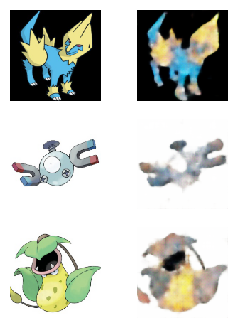

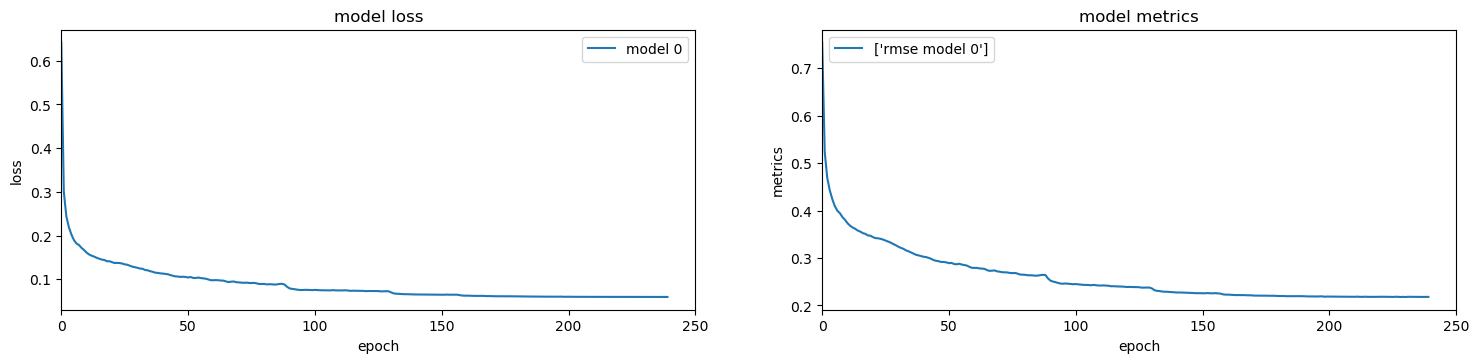

model 0          Step: 31s649ms | Loss: 0.060   | Rmse: 21.789%  | learning rate: 2.441e-07  ( 240/250 )
model 0          Step: 28s969ms | Loss: 0.060   | Rmse: 21.793%  | learning rate: 2.441e-07  ( 241/250 )
model 0          Step: 28s40ms  | Loss: 0.060   | Rmse: 21.832%  | learning rate: 2.441e-07  ( 242/250 )
model 0          Step: 31s546ms | Loss: 0.060   | Rmse: 21.780%  | learning rate: 2.441e-07  ( 243/250 )
learning rate changed! ( form 2.441e-07 to 1.221e-07)

Epoch 00244: ReduceLROnPlateau reducing learning rate to 1.220703125e-07.
model 0          Step: 39s462ms | Loss: 0.060   | Rmse: 21.800%  | learning rate: 1.221e-07  ( 244/250 )


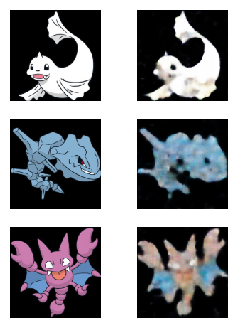

model 0          Step: 36s692ms | Loss: 0.060   | Rmse: 21.807%  | learning rate: 1.221e-07  ( 245/250 )
model 0          Step: 33s497ms | Loss: 0.060   | Rmse: 21.795%  | learning rate: 1.221e-07  ( 246/250 )
model 0          Step: 28s94ms  | Loss: 0.060   | Rmse: 21.813%  | learning rate: 1.221e-07  ( 247/250 )
learning rate changed! ( form 1.221e-07 to 6.104e-08)

Epoch 00248: ReduceLROnPlateau reducing learning rate to 6.103515625e-08.
model 0          Step: 27s443ms | Loss: 0.060   | Rmse: 21.805%  | learning rate: 6.104e-08  ( 248/250 )
model 0          Step: 28s981ms | Loss: 0.060   | Rmse: 21.788%  | learning rate: 6.104e-08  ( 249/250 )


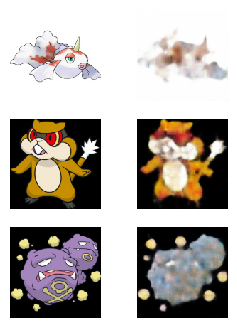

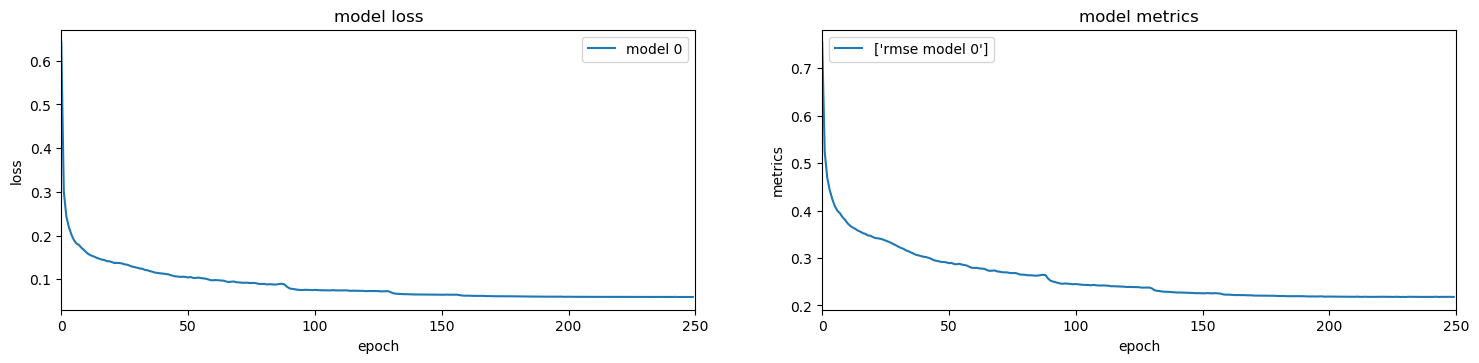

In [10]:
plan.start_now()

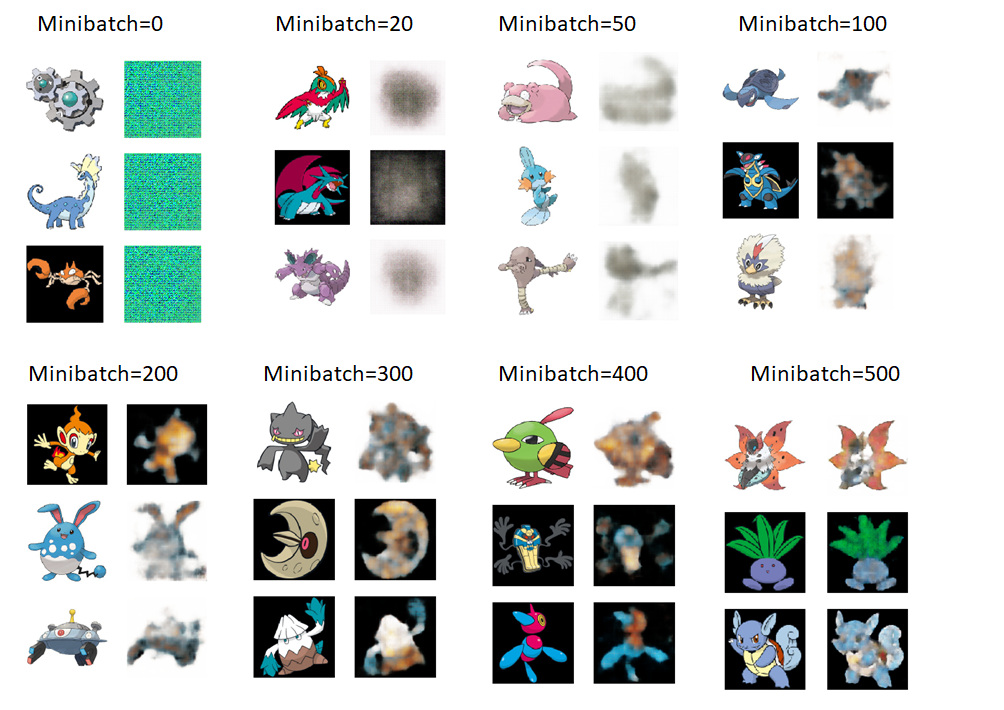

In [11]:
display.Image('../images/pokemon_training.png',width=800)

## 表徵學習 

In [17]:
features=[]


for img_data in dataset.get_all_data(get_image_mode = GetImageMode.processed):
    input=to_tensor(np.expand_dims(img_data,0))
    encoder_output = np.squeeze(to_numpy(autoencoder[0](input)))
    features.append(encoder_output)


features=np.stack(features)
print(features.shape)
   

(1444, 128)


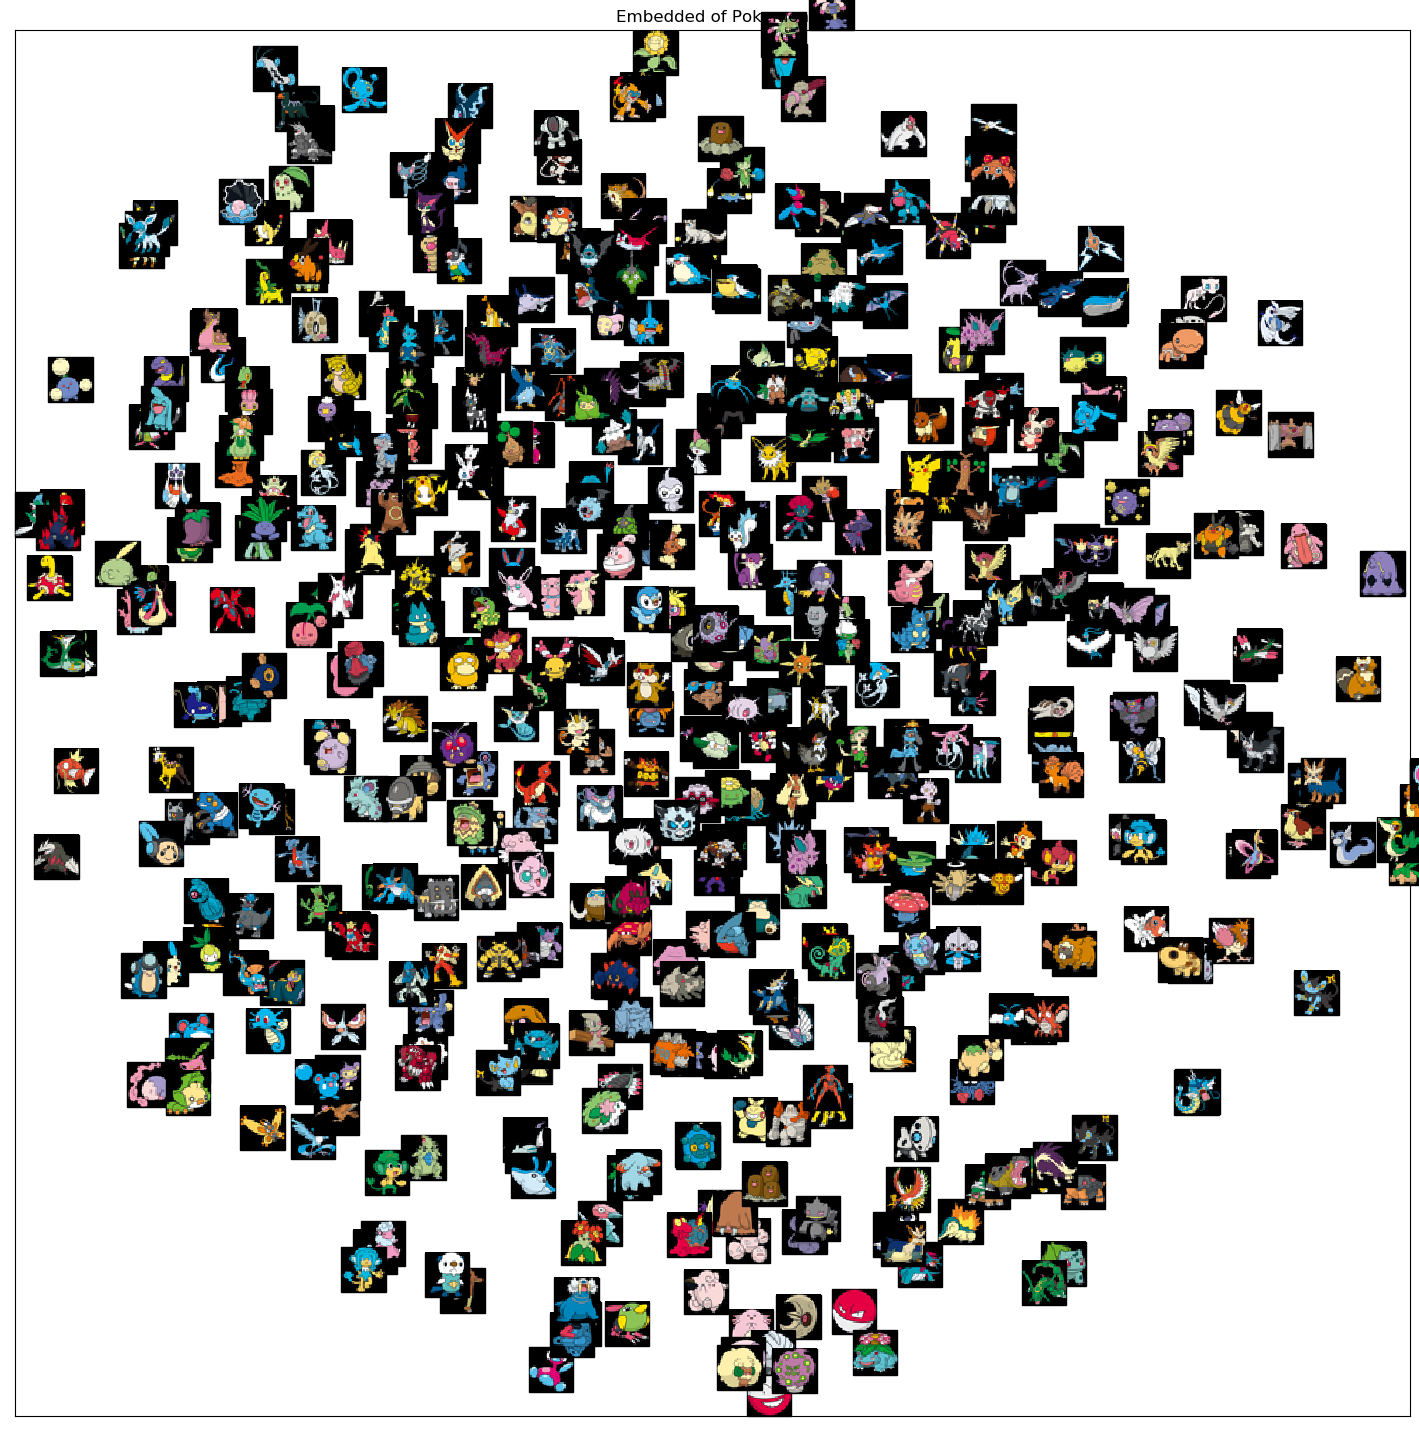

In [15]:
from matplotlib import offsetbox
from sklearn import manifold
import PIL
from PIL import Image as Image

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig =plt.figure(figsize=(18,18))
    ax = plt.subplot(111)
    imgdata=dataset.get_all_data(get_image_mode = GetImageMode.expect)
    if hasattr(offsetbox, 'AnnotationBbox'):
        # 需要matplotlib 版本> 1.0才支援顯示圖片功能
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
           
            shown_images = np.r_[shown_images, [X[i]]]
            #將向量轉圖片，且將圖片縮小至32*32
            img=array2image(imgdata[i]) #array2image是 trident 內的函數
            img = img.resize((32, 32),Image.ANTIALIAS)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img),X[i],pad=0, box_alignment=(0, 0))
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    display.display(fig)

#利用 t-SNE  降維
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)#利用t-sne將128特徵向量降維至2
X_tsne = tsne.fit_transform(features[:500,:])#為了避免圖片太密我只用了前500來處理

plot_embedding(X_tsne, "Embedded of Pokemon")#繪製圖像散布圖

## 寶可夢的相似性搜索 

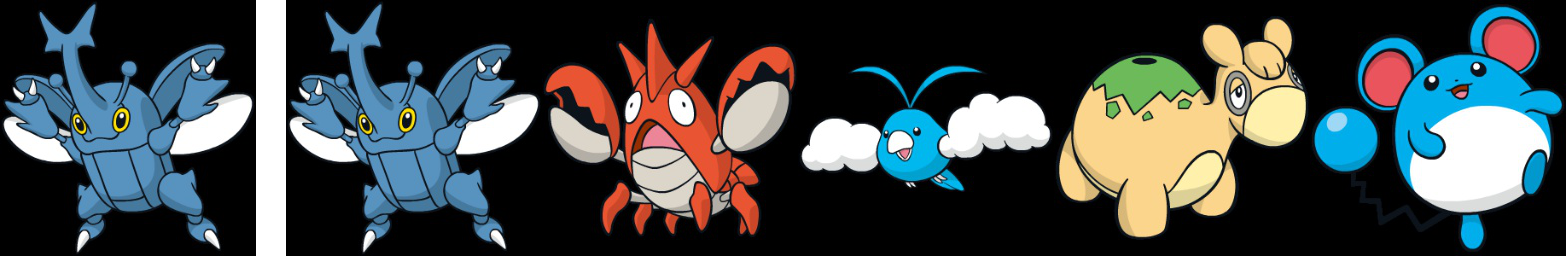

In [21]:
imgdata=np.array(dataset.get_all_data(get_image_mode = GetImageMode.raw))

def find_similar_pokemon(idx):
    similarity_list=[]
    result=to_numpy(element_cosine_distance(to_tensor(features[idx:idx+1,:]),to_tensor(features)))  #element_cosine_distance逐成員計算Cosine距離


    top5=np.argsort(result)[-5:][::-1]  #找出前 5個Cosine距離最高者(Cosine距離是越高越像)
    similarity_list=[imgdata[idx]] #放入原圖
    similarity_list.append(np.ones_like(similarity_list[0])[:,:30,:]*255) # 加入白色分隔線
    similarity_list.extend(imgdata[top5]) #放入前 5名圖 

    merge_img=np.concatenate(similarity_list,axis=1) #沿著寬(axis=1)疊合
    display.display(array2image(merge_img)) #顯示結果



idx=128 #抽取一隻寶可夢
find_similar_pokemon(idx)

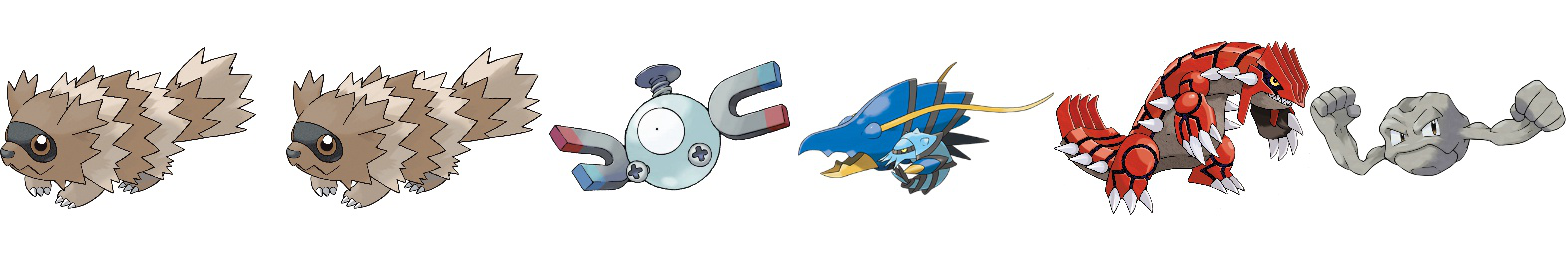

In [25]:
import random
find_similar_pokemon(random.choice(range(1444)))